# **Forecasting Demand for Course Enrollment in Higher Education**

## **Data Cleaning and Exploratory Data analysis (EDA)**

In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Load the tab-delimited datasets with appropriate encoding
section_data = pd.read_csv('../data/section', delimiter='\t', encoding='latin1')
term_data = pd.read_csv('../data/term', delimiter='\t', encoding='latin1')
student_cap_data = pd.read_csv('../data/student_cap', delimiter='\t', encoding='latin1')
instruction_data = pd.read_csv('../data/instruction', delimiter='\t', encoding='latin1')
delivery_data = pd.read_csv('../data/delivery', delimiter='\t', encoding='latin1')

In [3]:
# Display the first few rows of each dataset to understand the structure
section_data.head()

,section_id,course_code,term_code,crn,sec_num,status,delivery_code,cap,approval_code,note
0,30241,BIOL 181,201702,10001,1,Open,DCAM,80,IPAD,NaN
1,30242,BIOL 181L,201702,10002,1,Closed,DCAM,16,IPAD,NaN
2,30243,BIOL 181L,201702,10003,2,Open,DCAM,16,IPAD,NaN
3,30244,ALST 202,201702,10004,1,Open,DCAM,16,IPAD,NaN
4,30245,BIOL 181L,201702,10005,3,Closed,DCAM,16,IPAD,NaN


In [4]:
term_data.head()

,term_code,year,semester,begin,end
0,202202,2023,Spring,1/23/2023,5/5/2023
1,202201,2022,Fall,8/25/2022,12/9/2022
2,202102,2022,Spring,1/24/2022,5/6/2022
3,202101,2021,Fall,8/26/2021,12/10/2021
4,202002,2021,Spring,1/25/2021,4/30/2021


In [5]:
student_cap_data.head()

,section_id,category,cap,enrolled
0,38670,Sophomore,3,3
1,38670,Freshman,6,6
2,38670,General,9,8
3,38671,General,18,10
4,38672,General,9,12


In [6]:
instruction_data.head()

,instructor_code,section_id
0,ajimenez,30241
1,kingram,30241
2,cvisscher,30242
3,stanis,30243
4,cbannerhaley,30244


In [7]:
delivery_data.head()

,delivery_code,name,description
0,DOLS,"On-line, synchronous intruction",Instructor and all students will meet a the sa...
1,DCAM,"On-Campus, in-person instruction",Instructor and students will be on campus and ...
2,DHYB,Hybrid instruction,A combination of on-line and on-campus instruc...
3,DOLA,"On-line, asynchronous intruction",All instructional materials are available onli...


In [8]:
# Handling missing values by forward filling
section_data.fillna(method='ffill', inplace=True)
term_data.fillna(method='ffill', inplace=True)
student_cap_data.fillna(method='ffill', inplace=True)
instruction_data.fillna(method='ffill', inplace=True)
delivery_data.fillna(method='ffill', inplace=True)

In [9]:
# Convert date columns to datetime format
term_data['begin'] = pd.to_datetime(term_data['begin'])
term_data['end'] = pd.to_datetime(term_data['end'])

In [10]:
# Merge datasets
merged_data = pd.merge(section_data, term_data, left_on='term_code', right_on='term_code', how='inner')
merged_data = pd.merge(merged_data, student_cap_data, left_on='section_id', right_on='section_id', how='inner')
merged_data = pd.merge(merged_data, instruction_data, left_on='section_id', right_on='section_id', how='inner')
merged_data = pd.merge(merged_data, delivery_data, left_on='delivery_code', right_on='delivery_code', how='inner')

In [11]:
# Save the merged dataset for future use
merged_data.to_csv('cleaned_merged_data.csv', index=False)

# **Exploratory Data analysis (EDA)**

In [12]:
# Load the merged dataset
merged_data = pd.read_csv('../data/cleaned_merged_data.csv')

In [13]:
merged_data.shape

(11256, 20)

In [14]:
# Convert 'begin' column to datetime format again
merged_data['begin'] = pd.to_datetime(merged_data['begin'])

In [15]:
# Display the first few rows of the merged dataset
print("Merged Data")
merged_data.head()

Merged Data


,section_id,course_code,term_code,crn,sec_num,status,delivery_code,cap_x,approval_code,note,year,semester,begin,end,category,cap_y,enrolled,instructor_code,name,description
0,30241,BIOL 181,201702,10001,1,Open,DCAM,80,IPAD,NaN,2018,Spring,2018-01-22,2018-05-04,General,80,79,ajimenez,"On-Campus, in-person instruction",Instructor and students will be on campus and ...
1,30241,BIOL 181,201702,10001,1,Open,DCAM,80,IPAD,NaN,2018,Spring,2018-01-22,2018-05-04,General,80,79,kingram,"On-Campus, in-person instruction",Instructor and students will be on campus and ...
2,30242,BIOL 181L,201702,10002,1,Closed,DCAM,16,IPAD,NaN,2018,Spring,2018-01-22,2018-05-04,General,16,17,cvisscher,"On-Campus, in-person instruction",Instructor and students will be on campus and ...
3,30243,BIOL 181L,201702,10003,2,Open,DCAM,16,IPAD,NaN,2018,Spring,2018-01-22,2018-05-04,General,16,15,stanis,"On-Campus, in-person instruction",Instructor and students will be on campus and ...
4,30244,ALST 202,201702,10004,1,Open,DCAM,16,IPAD,NaN,2018,Spring,2018-01-22,2018-05-04,General,16,15,cbannerhaley,"On-Campus, in-person instruction",Instructor and students will be on campus and ...


In [16]:
# Summary Statistics for Numerical Data
numerical_data = merged_data.select_dtypes(include=[np.number])
print("Summary Statistics")
print(numerical_data.describe())

Summary Statistics
         section_id      term_code           crn       sec_num         cap_x  \
count  11256.000000   11256.000000  11256.000000  11256.000000  11256.000000   
mean   34893.433369  201979.054104  10447.408671      1.974769     19.917644   
std     2685.499020     160.236036    271.155366      2.369149     52.364626   
min    30241.000000  201702.000000  10001.000000      1.000000      0.000000   
25%    32547.750000  201802.000000  10215.000000      1.000000     14.000000   
50%    34884.500000  202001.000000  10438.000000      1.000000     18.000000   
75%    37239.250000  202102.000000  10662.000000      2.000000     23.000000   
max    39555.000000  202202.000000  11130.000000     24.000000   3000.000000   

               year         cap_y      enrolled  
count  11256.000000  11256.000000  11256.000000  
mean    2020.332623     16.401208     13.632107  
std        1.598663     52.210184     13.204241  
min     2018.000000      0.000000      0.000000  
25%     20

In [17]:
# Check for Missing Values
print("Missing Values")
print(merged_data.isnull().sum())

Missing Values
section_id          0
course_code         0
term_code           0
crn                 0
sec_num             0
status              0
delivery_code       0
cap_x               0
approval_code       0
note               10
year                0
semester            0
begin               0
end                 0
category            0
cap_y               0
enrolled            0
instructor_code     0
name                0
description         0
dtype: int64


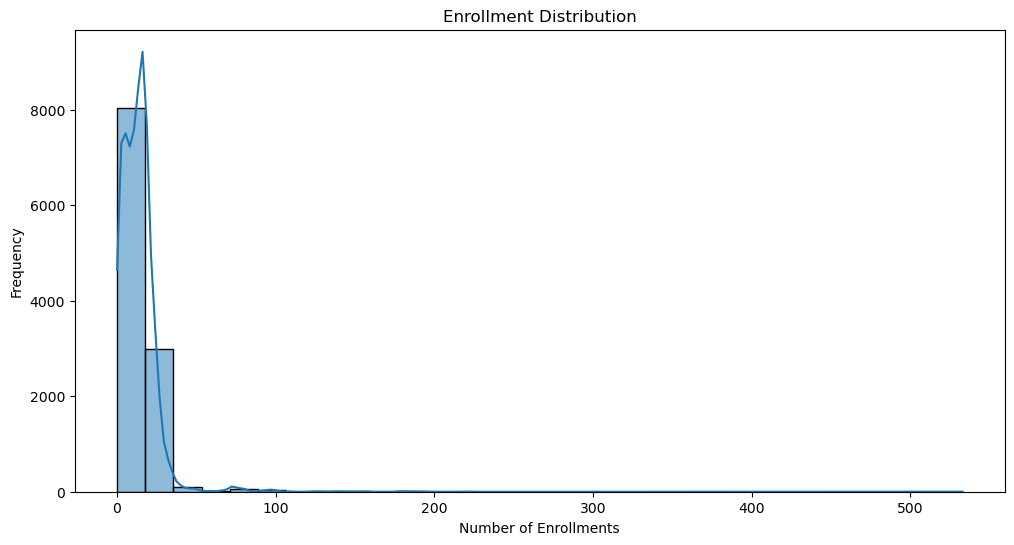

In [18]:
# Data Distribution
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['enrolled'], bins=30, kde=True)
plt.title('Enrollment Distribution')
plt.xlabel('Number of Enrollments')
plt.ylabel('Frequency')
plt.show()

### **Enrollment Distribution Analysis**

The histogram of enrollment distribution shows the frequency of different enrollment sizes.

#### **High Frequency at Low Enrollment Numbers**
- The majority of the courses have low enrollment numbers, specifically between 0 and 20 enrollments. This is indicated by the high bars on the left side of the histogram.
- The highest peak, around 8000, shows that most of the courses have enrollments close to zero.

#### **Long Tail**
- As the enrollment numbers increase, the frequency of such courses decreases drastically. This is indicated by the rapid drop in the height of the bars.
- There are very few courses with enrollments exceeding 100, and even fewer with enrollments going up to 400 or more.

#### **Skewed Distribution**
- The distribution is highly right-skewed, meaning that a large number of courses have low enrollment numbers, and a small number of courses have very high enrollments.
- This skewness is typical in educational data where a few popular courses attract a large number of students while many other courses have fewer enrollments.

#### **KDE Plot**
- The Kernel Density Estimate (KDE) plot overlays the histogram and shows the probability density function of the enrollments.
- The KDE curve further emphasizes the right-skewness and helps in understanding the distribution's overall shape.

### **Insights**

#### Course Popularity
- A small number of courses are extremely popular with high enrollments.
- Most courses have lower enrollments, indicating niche or specialized subjects.

#### **Resource Allocation**
- The high frequency of low-enrollment courses suggests a need to review these courses for resource allocation, potential merging, or offering on a less frequent basis.
- High-enrollment courses may need more resources like instructors, classrooms, and materials to accommodate the large number of students.

#### **Further Analysis**
- Analyzing the characteristics of high-enrollment courses can help understand what makes them popular (e.g., course content, instructor reputation, mandatory nature of the course).
- Analyzing the trends over time for enrollments can help in planning future course offerings.

This visualization provides a good starting point for understanding enrollment patterns in the dataset. Further analysis can provide more specific insights and recommendations for course management and planning.


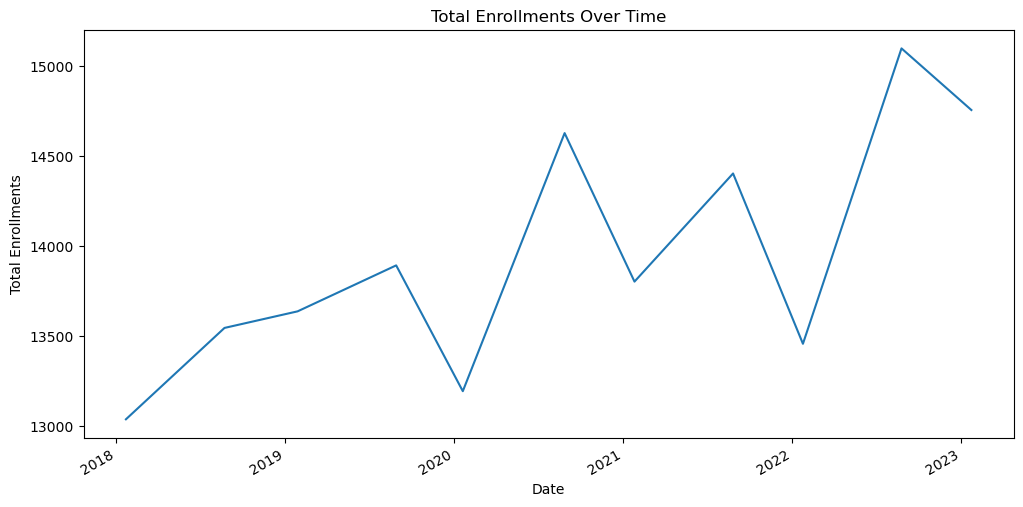

In [19]:
# Time Series Analysis
plt.figure(figsize=(12, 6))
merged_data.groupby('begin')['enrolled'].sum().plot()
plt.title('Total Enrollments Over Time')
plt.xlabel('Date')
plt.ylabel('Total Enrollments')
plt.show()

### **Total Enrollments Over Time Analysis**

The line chart visualizes the total enrollments over time, displaying how enrollments have changed from 2018 to 2023.

#### **Trends and Patterns**
- **2018 to 2020**: There is a steady increase in total enrollments from 13,000 in 2018 to around 14,500 in 2020.
- **2020 to 2021**: A sharp increase is observed in 2020, reaching a peak of approximately 15,000 enrollments. However, a significant drop follows in 2021.
- **2021 to 2023**: The trend from 2021 to 2023 shows notable fluctuations, with another peak occurring in 2022, followed by a decline and subsequent rise towards the end of the period.

#### **Insights**
- **Steady Growth**: The period between 2018 and 2020 indicates a steady growth in enrollments, suggesting an increasing interest or availability of courses.
- **Sharp Fluctuations**: The sharp fluctuations from 2020 onwards might be due to external factors such as changes in course offerings, academic policies, or external events impacting student enrollments.
- **Recent Trends**: The recent fluctuations highlight the need for further analysis to understand the underlying causes and to plan for more stable enrollment patterns in the future.

This visualization provides a clear overview of the enrollment trends over the years, which is crucial for understanding how enrollments evolve over time and for making informed decisions regarding course offerings and resource allocation.


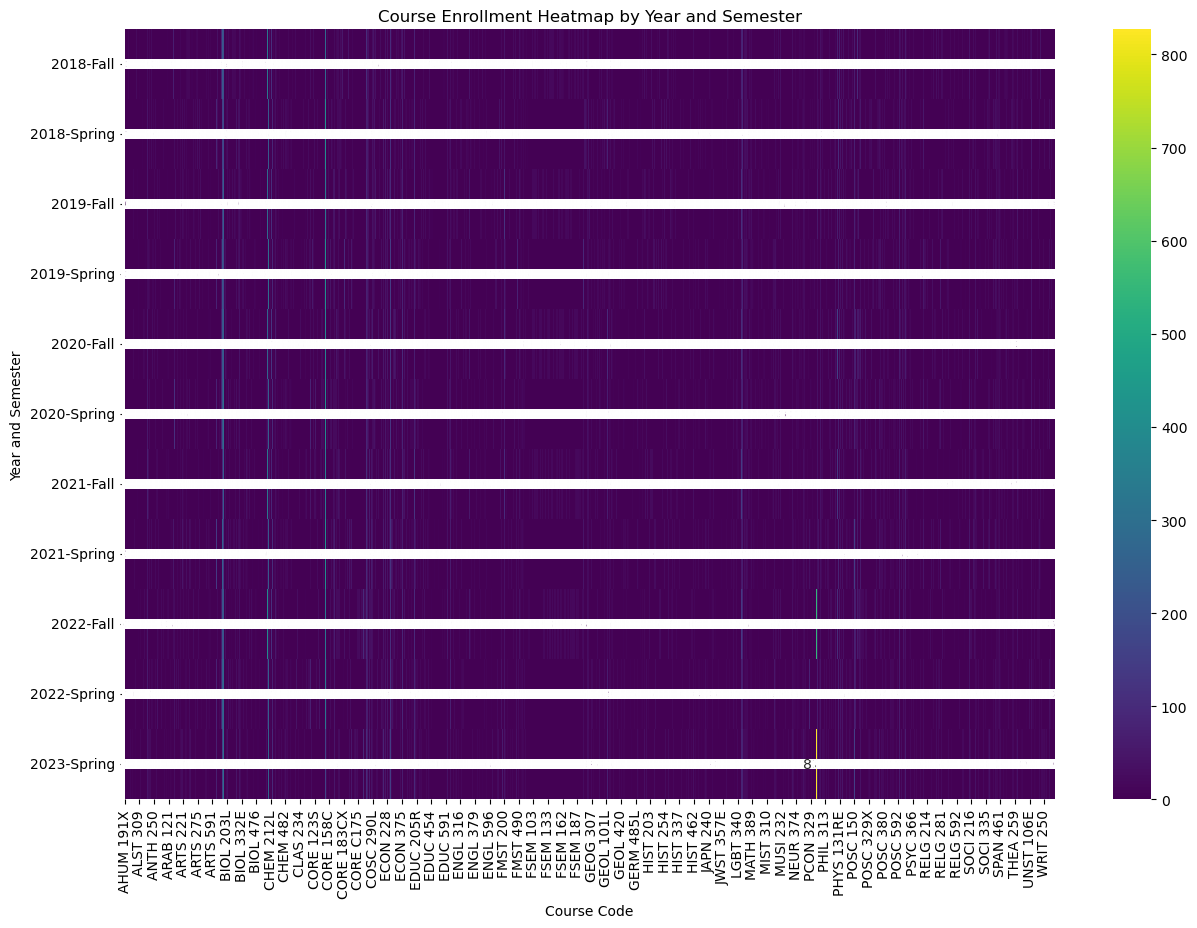

In [20]:
# Create a pivot table for course enrollment heatmap
pivot_table = merged_data.pivot_table(values='enrolled', index=['year', 'semester'], columns='course_code', aggfunc='sum', fill_value=0)

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d')
plt.title('Course Enrollment Heatmap by Year and Semester')
plt.xlabel('Course Code')
plt.ylabel('Year and Semester')
plt.xticks(rotation=90)
plt.show()

### **Course Enrollment Heatmap by Year and Semester**

The heatmap visualizes course enrollments across different years and semesters, providing insights into enrollment patterns for various courses over time.

#### **Trends and Patterns**
- **Year and Semester Segmentation**: The heatmap is segmented by year and semester, showing enrollment patterns for each course.
- **Consistent Enrollments**: The consistent dark shades across many courses indicate low enrollments across multiple semesters and years.
- **High Enrollment Courses**: The brighter spots in the heatmap indicate courses with higher enrollments. These spots are relatively sparse, indicating that only a few courses have significantly higher enrollments compared to others.

#### **Insights**
- **Low Enrollment Courses**: Most courses have low enrollments, as indicated by the dark shades dominating the heatmap. This suggests the need to evaluate the offering and scheduling of these courses.
- **High Enrollment Courses**: The bright spots highlight the courses with higher enrollments. These courses may be mandatory, popular electives, or core courses that attract more students.
- **Trends Over Time**: The heatmap helps identify any changes in course popularity over different semesters and years. Any noticeable shifts can provide insights into student preferences and course demand dynamics.

This heatmap offers a comprehensive view of how course enrollments vary over time, aiding in making informed decisions for course planning, resource allocation, and identifying trends in student preferences.


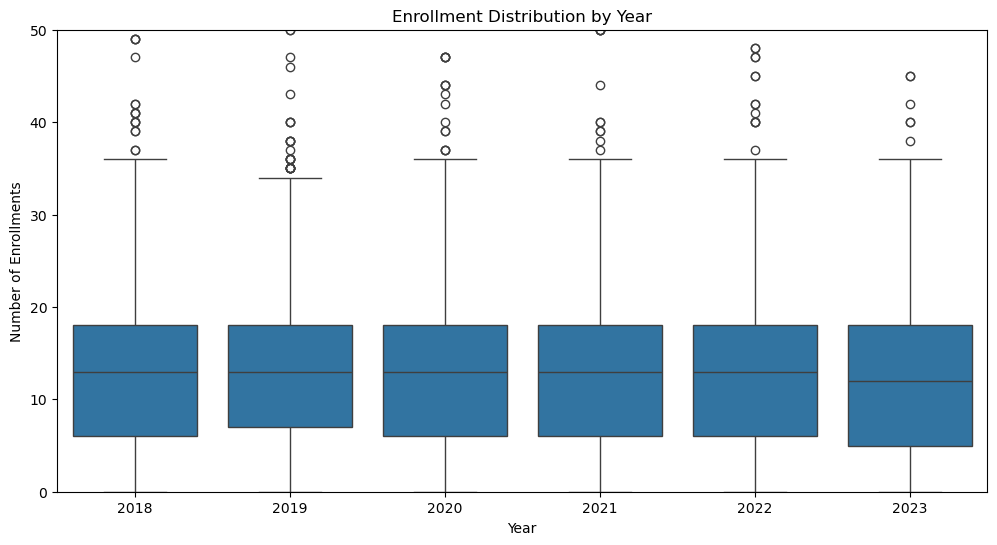

In [21]:
# Enrollment by Year (Zoomed)
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='enrolled', data=merged_data)
plt.title('Enrollment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Enrollments')
plt.ylim(0, 50)  # Adjust y-axis limit to zoom in on main data
plt.show()

### **Enrollment Distribution by Year**

The boxplot visualizes the distribution of enrollments per course across different years, from 2018 to 2023. The y-axis limit is adjusted to zoom in on the main data, enhancing readability.

#### Trends and Patterns
- **Consistent Medians**: The median number of enrollments per course remains relatively consistent across the years, hovering around 10 enrollments.
- **Interquartile Range (IQR)**: The IQR, representing the middle 50% of the data, is also consistent across the years. This suggests a stable central tendency in enrollments per course.
- **Outliers**: Each year shows a significant number of outliers, indicating courses with enrollments substantially higher than the typical range. These outliers often reach up to 50 enrollments or more.

#### Insights
- **Stable Central Tendency**: The stable medians and IQRs indicate that the central tendency of course enrollments has not changed significantly over the years.
- **High Enrollment Courses**: The presence of outliers each year highlights certain courses that consistently attract more students. These courses could be mandatory or particularly popular among students.
- **Resource Allocation**: Understanding the distribution of enrollments can aid in resource allocation, ensuring that high-enrollment courses are adequately supported.

This visualization provides a clear understanding of how enrollments per course have remained stable over time while also highlighting courses that attract significantly higher numbers of students.


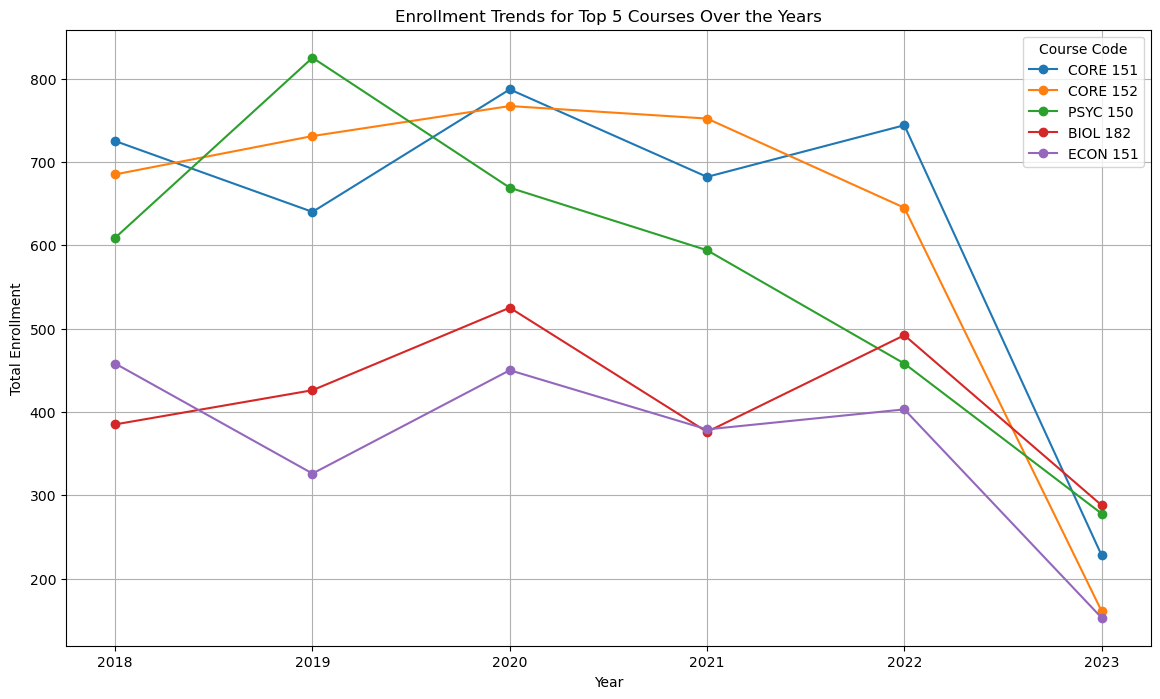

In [22]:
# Convert 'begin' column to datetime if it's not already in datetime format
merged_data['begin'] = pd.to_datetime(merged_data['begin'])

# Extract the year from 'begin' column
merged_data['begin_year'] = merged_data['begin'].dt.year

# Extracting the top 5 courses by total enrollment for visualization
top_courses = merged_data.groupby('course_code')['enrolled'].sum().sort_values(ascending=False).head(5).index
top_courses_data = merged_data[merged_data['course_code'].isin(top_courses)]

# Grouping by course code and year to get the enrollment trends for each top course
course_enrollment_trends = top_courses_data.groupby(['course_code', 'begin_year'])['enrolled'].sum().unstack('course_code').fillna(0)

# Plotting the enrollment trends for the top courses
plt.figure(figsize=(14, 8))
for course in top_courses:
    plt.plot(course_enrollment_trends.index, course_enrollment_trends[course], marker='o', label=course)

plt.title('Enrollment Trends for Top 5 Courses Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Enrollment')
plt.legend(title='Course Code')
plt.grid(True)
plt.show()

### **Interpretation of the Enrollment Trends Graph**

This graph depicts the enrollment trends for the top 5 courses (CORE 151, CORE 152, PSYC 150, BIOL 182, ECON 151) over the years 2018 to 2023. The x-axis represents the years, and the y-axis represents the total enrollment for each course.

#### **Key Observations:**

1. **CORE 151 (Blue) and CORE 152 (Orange)**:
   - **CORE 151**: 
     - The enrollment has remained relatively stable from 2018 to 2021, with slight fluctuations. 
     - There is a notable decline in enrollment from 2021 to 2023.
   - **CORE 152**:
     - There is an initial slight increase in enrollment from 2018 to 2019.
     - Similar to CORE 151, there is a significant decline from 2021 onwards, with a sharp drop from 2022 to 2023.

2. **PSYC 150 (Green)**:
   - The enrollment peaked in 2019 and remained high until 2021.
   - From 2021, there is a steady decline, with a sharp drop in 2023.

3. **BIOL 182 (Red)**:
   - The enrollment has shown moderate fluctuations with a peak in 2019 and a low in 2021.
   - There is an increasing trend from 2021 to 2022 but again a sharp decline in 2023.

4. **ECON 151 (Purple)**:
   - The enrollment started relatively lower compared to other courses.
   - There is a peak in 2019 followed by a decline in 2020, with some recovery in 2021.
   - Similar to other courses, there is a sharp drop in 2023.

#### **Overall Trends:**

- **2018-2021**: Most courses showed stability or slight increases in enrollments, with some fluctuations. 
- **2021-2023**: There is a consistent trend of declining enrollments across all courses.
- **Sharp Declines in 2023**: All the top courses exhibit a sharp decline in enrollment in 2023. This could indicate external factors affecting enrollment, such as policy changes, shifts in student interest, or institutional changes.


### **Filtering courses based on delivery codes**

**DOLS**	**On-line, synchronous intruction**	Instructor and all students will meet a the same time using a digital meeting technology such as Zoom.

**DCAM**	**On-Campus, in-person instruction**	Instructor and students will be on campus and meet face to face for instruction. Instructor may make provision for students to attend remotely with a digital meeting technology, such as Zoom.

**DHYB**	**Hybrid instruction**	A combination of on-line and on-campus instruction. For some sessions, students will meet face-to-face; for others, instructor and students will meet using a digital meeting technology, such as Zoom.

**DOLA**	**On-line, asynchronous intruction**	All instructional materials are available online and students may engage them at the time of their choosing. Instructors may set specific deadlines for engaging particular materials.


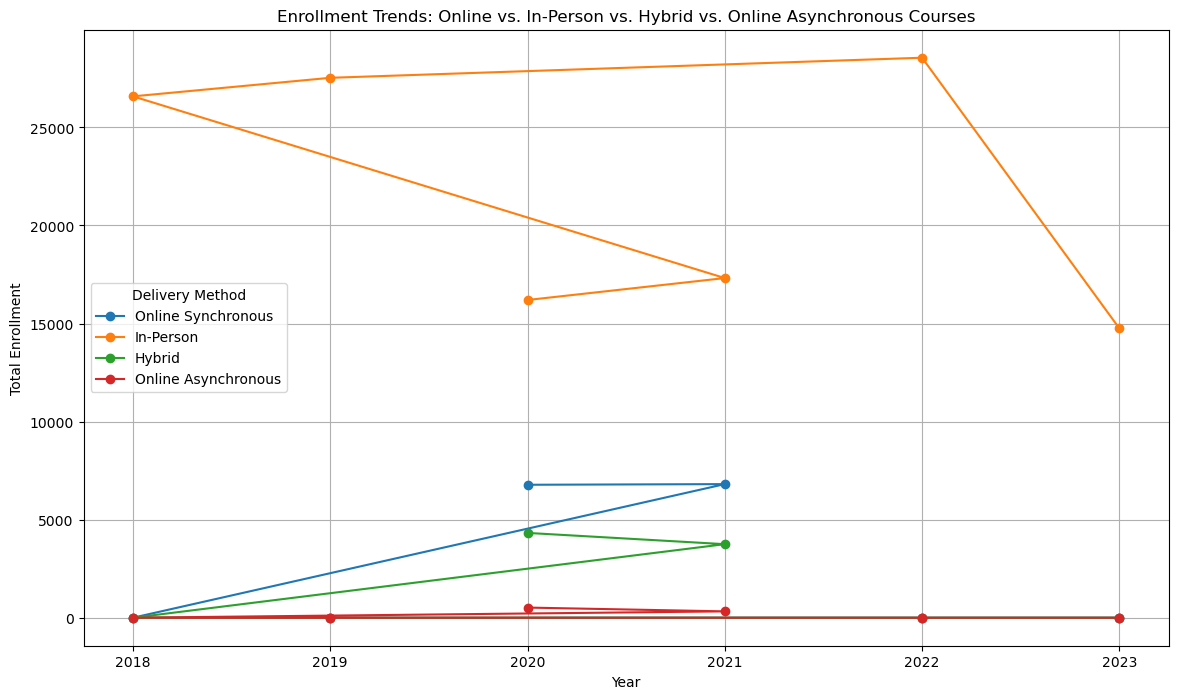

In [23]:
# Filtering courses based on delivery codes
online_synchronous = merged_data[merged_data['delivery_code'].str.contains('DOLS', case=False, na=False)]
in_person = merged_data[merged_data['delivery_code'].str.contains('DCAM', case=False, na=False)]
hybrid = merged_data[merged_data['delivery_code'].str.contains('DHYB', case=False, na=False)]
online_asynchronous = merged_data[merged_data['delivery_code'].str.contains('DOLA', case=False, na=False)]

# Grouping by year to get the total enrollment trends for each delivery method
online_sync_trends = online_synchronous.groupby('begin_year')['enrolled'].sum().reset_index(name='online_synchronous_enrollment')
in_person_trends = in_person.groupby('begin_year')['enrolled'].sum().reset_index(name='in_person_enrollment')
hybrid_trends = hybrid.groupby('begin_year')['enrolled'].sum().reset_index(name='hybrid_enrollment')
online_async_trends = online_asynchronous.groupby('begin_year')['enrolled'].sum().reset_index(name='online_asynchronous_enrollment')

# Merging the trends for comparison
enrollment_comparison = pd.merge(online_sync_trends, in_person_trends, on='begin_year', how='outer').fillna(0)
enrollment_comparison = pd.merge(enrollment_comparison, hybrid_trends, on='begin_year', how='outer').fillna(0)
enrollment_comparison = pd.merge(enrollment_comparison, online_async_trends, on='begin_year', how='outer').fillna(0)

# Plotting the comparison
plt.figure(figsize=(14, 8))
plt.plot(enrollment_comparison['begin_year'], enrollment_comparison['online_synchronous_enrollment'], marker='o', label='Online Synchronous')
plt.plot(enrollment_comparison['begin_year'], enrollment_comparison['in_person_enrollment'], marker='o', label='In-Person')
plt.plot(enrollment_comparison['begin_year'], enrollment_comparison['hybrid_enrollment'], marker='o', label='Hybrid')
plt.plot(enrollment_comparison['begin_year'], enrollment_comparison['online_asynchronous_enrollment'], marker='o', label='Online Asynchronous')
plt.title('Enrollment Trends: Online vs. In-Person vs. Hybrid vs. Online Asynchronous Courses')
plt.xlabel('Year')
plt.ylabel('Total Enrollment')
plt.legend(title='Delivery Method')
plt.grid(True)
plt.show()

### **Interpretation of the Enrollment Trends by Delivery Method Graph**

This graph displays the enrollment trends for different delivery methods (Online Synchronous, In-Person, Hybrid, Online Asynchronous) from 2018 to 2023. The x-axis represents the years, and the y-axis represents the total enrollment for each delivery method.

#### **Key Observations:**

1. **In-Person (Orange)**:
   - The enrollment for in-person courses starts very high, around 25,000 in 2018.
   - There is a steady increase in enrollment up to 2021, peaking just below 30,000.
   - However, there is a sharp decline in enrollment in 2022 and a drastic drop in 2023 to below 10,000.

2. **Online Synchronous (Blue)**:
   - The enrollment shows a gradual increase from 2018 to 2021.
   - Enrollment stabilizes around 5,000 from 2020 onwards, indicating steady demand.

3. **Hybrid (Green)**:
   - The enrollment for hybrid courses shows moderate growth from 2018 to 2020.
   - There is a slight increase in enrollment in 2021, stabilizing around 2,000 enrollments.
   - Similar to other methods, hybrid courses show a decline in 2022 and 2023.

4. **Online Asynchronous (Red)**:
   - Enrollment for online asynchronous courses is very low compared to other delivery methods.
   - There is minimal change in enrollment from 2018 to 2023, remaining close to zero.

#### **Overall Trends:**

- **In-Person Dominance**: In-person courses have historically dominated enrollments, but the sharp decline in 2022 and 2023 indicates a significant shift away from traditional in-person learning.
- **Steady Growth in Online Synchronous and Hybrid**: Both online synchronous and hybrid courses show steady growth, indicating an increasing preference for flexible learning options.
- **Low Adoption of Online Asynchronous**: Despite the flexibility, online asynchronous courses have very low enrollment, suggesting that students may prefer more interactive or structured learning environments.